In [4]:
#Title: Energy forecasting using LSTM Networks
#Author: Arslan Ahmed (arslan.m.ahmed@gmail.com)
#Date: 2nd March, 2018

#import all packages that we may need

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.cross_validation import KFold # use for cross validation
from sklearn import preprocessing # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import ExtraTreesClassifier
from scipy import signal

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from pandas import concat
import matplotlib.dates as md
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
#function to convert time series data to apply supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [6]:
#read energy data

df_e = pd.read_csv('UKdata_energy.csv', parse_dates={'time_e' : ['Time']}, infer_datetime_format=True, na_values=['nan','?'], index_col='time_e')

In [7]:
#read weather data

df_w = pd.read_csv('UKdata_weather.csv', parse_dates={'time_w' : ['time']}, infer_datetime_format=True, na_values=['nan','?'], index_col='time_w')

In [8]:
#select data from 1st Jan 2013 to 28th Feb 2014
df_e=df_e['2013-01-01':'2014-02-28']
df_w=df_w['2013-01-01':'2014-02-28']

In [9]:
df_w=df_w.resample('30min').mean()
df_e=df_e.resample('30min').mean()

In [10]:
df = pd.concat([df_e, df_w], axis=1, join='inner')

In [11]:
df=df.interpolate(method='linear')

In [12]:
df['Day of week'] = df.index.weekday.astype(int)
df["Weekend"] = (df["Day of week"] > 5).astype(int)
df.iloc[:,0:3] *= 1000

In [13]:
no_of_features=len(df.columns)

In [14]:
#removing outliers
df[df.D0009 > df.D0009.quantile(.9)]=np.nan #data above 90 percentile will be filled with NaN
df[df.D0664 > df.D0664.quantile(.9)]=np.nan
df[df.D0935 > df.D0935.quantile(.9)]=np.nan
df=df.fillna(method='pad')

In [15]:
#drop features that are correlated with each other
df=df.drop(df.columns[[0,6,8]], axis=1)
#df=df.drop(df.columns[1:], axis=1)

In [16]:
#revised no. of features after dropping correlated features
no_of_features=len(df.columns)

In [17]:
#data scaling from 0 to 1 of original data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

In [18]:
no_of_timesteps=1
reframed = series_to_supervised(scaled, no_of_timesteps, 1)
# print(reframed.head())

In [19]:
# drop columns we don't want to predict
col_array=np.arange(0,len(reframed.columns))
reframed=reframed.loc[:,(col_array<no_of_features*no_of_timesteps+1) | (col_array%(no_of_features)==0)]

In [53]:
error_days=[]

loop 7
151.99695793537683
loop 14
136.03243948851136
loop 21
124.15259580808294
loop 28
119.35136631156541
loop 35
118.51352977880319
loop 42
117.55908470423427
loop 49
118.0596162163903
loop 56
118.32791134085558
loop 63
120.35730007085989
loop 70
120.09532117599217
loop 77
120.60729852900698


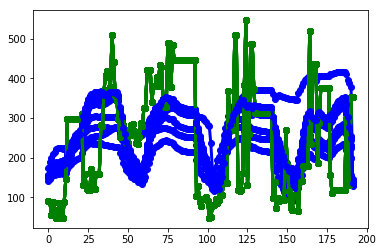

In [54]:

for p in range(7,84,7):
    print('loop', p)
    n_train_time = 2*24*84; # hours used for training.....
    original_n_train_time=n_train_time;
    pred_list=[]; #predicted values that will replace the original test_y values
    testing_rows=2*24*4;#hours to predict
    #testing_rows=reframed.shape[0]-original_n_train_time-1
    test1 = reframed.values[n_train_time:n_train_time+testing_rows, :] #original testing data, this will later be modified with the predicted data generated by for loop
    test_y1 = test1[:, -1] #see comment in above line
    train = reframed.values[n_train_time-2*24*p:n_train_time, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    svr_rbf = SVR(kernel='rbf', C=100, gamma=0.01);
    svr_rbf.fit(train_X, train_y);
    for j in range(0,testing_rows):
    #     print('Loop # ',j)
        test = reframed.values[n_train_time:n_train_time+1, :]
        test_X = test[:, :-1]
    #     test_X = test_X.reshape((test_X.shape[0], no_of_timesteps, no_of_features))
        yhat = svr_rbf.predict(test_X)
        for k in range(0,len(reframed.columns),no_of_features):
            if((k+no_of_features)<(len(reframed.columns)-1)):
                reframed.values[n_train_time+1,k]=reframed.values[n_train_time,(k+no_of_features)];
        reframed.values[n_train_time+1,(len(reframed.columns)-1-no_of_features)]=yhat;
    #     reframed.values[n_train_time+1,0]=yhat;
        n_train_time=n_train_time+1
        pred_list=np.append(pred_list,yhat)
    #     print(reframed[n_train_time-1:n_train_time])
    #     print(yhat)
    n_train_time=original_n_train_time
    x_max=df.iloc[:,0].max()
    x_min=df.iloc[:,0].min()
    test_y1_un_scaled=test_y1*(x_max-x_min)+x_min
    pred_list_un_scaled=pred_list*(x_max-x_min)+x_min
    rmse=np.sqrt(mean_squared_error(test_y1_un_scaled, np.roll(pred_list_un_scaled, -1)))
    error_days.append(rmse)
    print(rmse)
    plt.plot(test_y1_un_scaled,'go-', label='True data', linewidth=3)
    plt.plot(np.roll(pred_list_un_scaled, -1),'bo-',label='Predicted Data', linewidth=3)

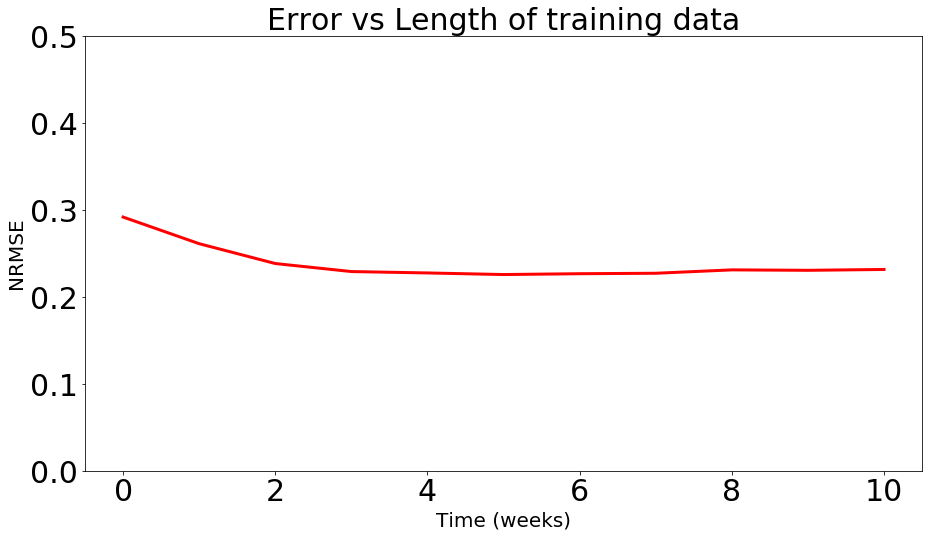

In [55]:
plt.figure(figsize=(15,8))    
# plt.bar(range(len(error_days/(x_max-x_min))), error_days/(x_max-x_min))
plt.plot(error_days/(x_max-x_min),'r-',linewidth=3)
plt.ylabel('NRMSE', fontsize=20)
plt.xlabel('Time (weeks)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)    

# x=np.arange(0,len(test_y1_un_scaled),24)
# y=df.index.strftime('%d-%b\n%I-%M-%p')[original_n_train_time::24]
# plt.xticks(x, y, rotation=80);

plt.ylim(ymin=0, ymax=0.5)
plt.title('Error vs Length of training data', fontsize=30)
plt.savefig('F_Error_train.pdf', bbox_inches='tight')
plt.tick_params(axis='both', which='major', labelsize=30)


In [39]:
error_days

[151.99695793537683,
 136.03243948851136,
 124.15259580808294,
 119.35136631156541,
 118.51352977880319,
 117.55908470423427,
 118.0596162163903,
 118.32791134085558,
 120.35730007085989,
 120.09532117599217,
 120.60729852900698]